<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setup" data-toc-modified-id="Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup</a></span><ul class="toc-item"><li><span><a href="#Check-your-sample-table-(i.e.-metadata-file)" data-toc-modified-id="Check-your-sample-table-(i.e.-metadata-file)-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Check your sample table (i.e. metadata file)</a></span></li><li><span><a href="#Check-your-TRN" data-toc-modified-id="Check-your-TRN-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Check your TRN</a></span></li><li><span><a href="#Load-the-data" data-toc-modified-id="Load-the-data-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Load the data</a></span></li></ul></li><li><span><a href="#Regulatory-iModulons" data-toc-modified-id="Regulatory-iModulons-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Regulatory iModulons</a></span></li><li><span><a href="#Functional-iModulons" data-toc-modified-id="Functional-iModulons-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Functional iModulons</a></span><ul class="toc-item"><li><span><a href="#GO-Enrichments" data-toc-modified-id="GO-Enrichments-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>GO Enrichments</a></span></li><li><span><a href="#KEGG-Enrichments" data-toc-modified-id="KEGG-Enrichments-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>KEGG Enrichments</a></span><ul class="toc-item"><li><span><a href="#Load-KEGG-mapping" data-toc-modified-id="Load-KEGG-mapping-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Load KEGG mapping</a></span></li><li><span><a href="#Perform-enrichment" data-toc-modified-id="Perform-enrichment-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>Perform enrichment</a></span></li><li><span><a href="#Convert-KEGG-IDs-to-human-readable-names" data-toc-modified-id="Convert-KEGG-IDs-to-human-readable-names-3.2.3"><span class="toc-item-num">3.2.3&nbsp;&nbsp;</span>Convert KEGG IDs to human-readable names</a></span></li></ul></li></ul></li><li><span><a href="#Check-for-single-gene-iModulons" data-toc-modified-id="Check-for-single-gene-iModulons-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Check for single gene iModulons</a></span></li><li><span><a href="#Characterization" data-toc-modified-id="Characterization-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Characterization</a></span></li><li><span><a href="#Save-iModulon-object" data-toc-modified-id="Save-iModulon-object-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Save iModulon object</a></span></li></ul></div>

# Setup
This IPython notebook will walk through the steps of characterizing iModulons through the semi-automated tools in PyModulon. You will need:

* M and A matrices
* Expression data (e.g. `log_tpm_norm.csv`)
* Gene table and KEGG/GO annotations (Generated in `gene_annotation.ipynb`)
* Sample table, with a column for `project` and `condition`
* TRN file

Optional:
* iModulon table (if you already have some characterized iModulons)

In [1]:
from pymodulon.core import IcaData
from pymodulon.plotting import *
from pymodulon.io import *
from pymodulon.util import explained_variance
from pymodulon.compare import *
from os import path
import pandas as pd
import re
from Bio.KEGG import REST
from tqdm.notebook import tqdm
from matplotlib_venn import venn2, venn3

In [2]:
import matplotlib
import matplotlib.font_manager
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
# plt.rc('font', family='sans-serif', size=16)
plt.rc('text', usetex=False)
plt.rc('font', serif='Arial')
plt.rcParams['axes.axisbelow'] = True

In [3]:
warnings.filterwarnings("ignore")

## Check your sample table (i.e. metadata file)
Your metadata file will probably have a lot of columns, most of which you may not care about. Feel free to save a secondary copy of your metadata file with only columns that seem relevant to you. The two most important columns are:
1. `project`
2. `condition`

Make sure that these columns exist in your metadata file

In [4]:
df_metadata = pd.read_csv('../processed_data/metadata.tsv',index_col=0,sep='\t')
df_metadata[['project','condition']].head()

,project,condition
p1k_00132,42c,wt_42c
p1k_00133,42c,42c_ale1
p1k_00134,42c,42c_ale2
p1k_00135,42c,42c_ale3
p1k_00136,42c,42c_ale4


In [5]:
print(df_metadata.project.notnull().all())
print(df_metadata.condition.notnull().all())

True
True


## Check your TRN

Each row of the TRN file represents a regulatory interaction.  
**Your TRN file must have the following columns:**
1. `regulator` - Name of regulator (`/` or `+` characters will be converted to `;`)
1. `gene_id` - Locus tag of gene being regulated

The following columns are optional, but are helpful to have:
1. `regulator_id` - Locus tag of regulator
1. `gene_name` - Name of gene (can automatically update this using `name2num`)
1. `direction` - Direction of regulation ('+' for activation, '-' for repression, '?' or NaN for unknown)
1. `evidence` - Evidence of regulation (e.g. ChIP-exo, qRT-PCR, SELEX, Motif search)
1. `PMID` - Reference for regulation

You may add any other columns that could help you. TRNs may be saved as either CSV or TSV files. See below for an example:

In [6]:
df_trn = pd.read_csv('../processed_data/TRN.csv')
df_trn.head()

,regulator,gene_name,gene_id,effect,evidence,source
0,AccB,accB,b3255,-,0.0,RegulonDB_TF
1,RpoD,pheU,b4134,+,0.0,RegulonDB_sigma
2,RpoD,pheP,b0576,+,0.0,RegulonDB_sigma
3,RpoD,pheL,b2598,+,0.0,RegulonDB_sigma
4,RpoD,pheA,b2599,+,0.0,RegulonDB_sigma


The `regulator` and `gene_id` must be filled in for each row

In [7]:
print(df_trn.regulator.notnull().all())
print(df_trn.gene_id.notnull().all())

True
True


## Load the data
You're now ready to load your IcaData object!

In [8]:
ica_data = IcaData(M = '../interim/ica_runs/200_optimal/M.csv',
                   A = '../interim/ica_runs/200_optimal/A.csv',
                   X = '../processed_data/log_tpm_norm.csv',
                   gene_table = '../processed_data/gene_info.csv',
                   sample_table = '../processed_data/metadata.tsv',
                   trn = '../processed_data/TRN.csv',
                   optimize_cutoff=True)

# Regulatory iModulons
Use `compute_trn_enrichment` to automatically check for Regulatory iModulons. The more complete your TRN, the more regulatory iModulons you'll find.

In [9]:
# ica_data.compute_trn_enrichment()

You can also search for AND/OR combinations of regulators using the `max_regs` argument.

Regulator enrichments can be directly saved to the `imodulon_table` using the `save` argument. This saves the enrichment with the lowest q-value to the table.

In [10]:
# First search for regulator enrichments with 2 regulators
ica_data.compute_trn_enrichment(max_regs=2,save=True)

# Next, search for regulator enrichments with just one regulator. This will supercede the 2 regulator enrichments.
ica_data.compute_trn_enrichment(max_regs=1,save=True)

,imodulon,regulator,pvalue,qvalue,precision,recall,f1score,TP,regulon_size,imodulon_size,n_regs
0,1,Fur,1.685496e-44,5.393588e-43,0.820513,0.250000,0.383234,32.0,128.0,39.0,1.0
1,1,IscR,7.189392e-14,1.150303e-12,0.256410,0.303030,0.277778,10.0,33.0,39.0,1.0
2,1,RpoD,2.505662e-09,2.672706e-08,0.820513,0.020645,0.040277,32.0,1550.0,39.0,1.0
3,1,OxyR,4.535873e-08,3.628698e-07,0.179487,0.170732,0.175000,7.0,41.0,39.0,1.0
4,1,ryhB,7.737085e-07,4.126446e-06,0.179487,0.114754,0.140000,7.0,61.0,39.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
266,131,Mlc,6.204798e-10,2.419871e-08,0.217391,0.500000,0.303030,5.0,10.0,23.0,1.0
267,131,Crp,5.437137e-08,1.060242e-06,0.608696,0.025547,0.049037,14.0,548.0,23.0,1.0
268,131,sgrS,1.187027e-07,1.543135e-06,0.173913,0.400000,0.242424,4.0,10.0,23.0,1.0
269,131,CytR,3.999583e-07,3.899593e-06,0.173913,0.307692,0.222222,4.0,13.0,23.0,1.0


The list of regulatory iModulons are shown below

In [11]:
regulatory_imodulons = ica_data.imodulon_table[ica_data.imodulon_table.regulator.notnull()]
print(len(ica_data.imodulon_table),'Total iModulons')
print(len(regulatory_imodulons),'Regulatory iModulons')
regulatory_imodulons

132 Total iModulons
97 Regulatory iModulons


,regulator,pvalue,qvalue,precision,recall,f1score,TP,regulon_size,imodulon_size,n_regs
1,Fur,1.685496e-44,5.393588e-43,0.820513,0.250000,0.383234,32.0,128.0,39.0,1.0
4,RpoH,1.808843e-41,5.245645e-40,0.815789,0.219858,0.346369,31.0,141.0,38.0,1.0
5,YieP,2.142914e-17,3.214371e-16,0.600000,1.000000,0.750000,6.0,6.0,10.0,1.0
6,NtrC,1.602486e-16,2.403729e-15,1.000000,0.160000,0.275862,8.0,50.0,8.0,1.0
7,Zur,1.867378e-18,3.548018e-17,0.437500,1.000000,0.608696,7.0,7.0,16.0,1.0
...,...,...,...,...,...,...,...,...,...,...
126,LldR,0.000000e+00,0.000000e+00,1.000000,1.000000,1.000000,3.0,3.0,3.0,1.0
128,dsrA,3.439163e-14,1.719582e-13,1.000000,0.454545,0.625000,5.0,11.0,5.0,1.0
129,RstA,1.706395e-07,9.385174e-07,0.500000,0.300000,0.375000,3.0,10.0,6.0,1.0
130,ryhB,5.733128e-16,8.599692e-15,0.818182,0.147541,0.250000,9.0,61.0,11.0,1.0


You can rename iModulons in this jupyter notebook, or you can save the iModulon table as a CSV and edit it in Excel.

If two iModulons have the same regulator (e.g. 'Reg'), they will be named 'Reg-1' and 'Reg-2'

In [12]:
# ica_data.rename_imodulons(regulatory_imodulons.regulator.to_dict())
# ica_data.imodulon_table.head()

In [13]:
# regulatory_imodulons = ica_data.imodulon_table[ica_data.imodulon_table.regulator.notnull()]

# Functional iModulons

GO annotations and KEGG pathways/modules were generated in the 1_create_the_gene_table.ipynb notebook. Enrichments will be calculated in this notebook, and further curated in the 3_manual_iModulon_curation notebook.

## GO Enrichments

First load the Gene Ontology annotations

In [14]:
DF_GO = pd.read_csv('../external/GO_annotations_curated.csv',index_col=0)
DF_GO.head()

,gene_id,gene_name,gene_ontology
0,b1931,yedK,protein-DNA covalent cross-linking
1,b1931,yedK,DNA binding
2,b1931,yedK,single-stranded DNA binding
3,b1931,yedK,single-stranded DNA binding
4,b1931,yedK,single-stranded DNA binding


In [15]:
all_genes = set([])
for i in ica_data.imodulon_names:
    genes = ica_data.view_imodulon(i).index
    all_genes = all_genes.union(set(genes))

In [16]:
DF_GO[DF_GO['gene_id'].isin(all_genes)]

,gene_id,gene_name,gene_ontology
19,b1932,yedL,transferase activity
20,b1932,yedL,acyltransferase activity
21,b1932,yedL,"acyltransferase activity, transferring groups ..."
22,b1687,ydiJ,catalytic activity
23,b1687,ydiJ,oxidoreductase activity
...,...,...,...
62831,b1305,pspB,regulation of cellular response to stress
62832,b1305,pspB,plasma membrane
62833,b1305,pspB,plasma membrane
62834,b1305,pspB,plasma membrane


In [17]:
set(DF_GO.gene_id)-set(ica_data.X.index)

{'b4412', 'b4510', 'b4689'}

In [18]:
DF_GO = DF_GO[DF_GO.gene_id != 'b4412']
DF_GO = DF_GO[DF_GO.gene_id != 'b4510']
DF_GO = DF_GO[DF_GO.gene_id != 'b4689']

In [19]:
DF_GO_enrich = ica_data.compute_annotation_enrichment(DF_GO,'gene_ontology')

In [20]:
DF_GO_enrich.head()

,imodulon,gene_ontology,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size
0,0,transposition,1.333286e-16,5.626469e-13,0.145985,0.344828,0.205128,20.0,62.0,137.0
1,0,DNA recombination,5.545859e-12,1.170176e-08,0.153285,0.196262,0.172131,21.0,184.0,137.0
2,0,DNA transposition,1.571550e-10,2.210646e-07,0.102190,0.280000,0.149733,14.0,65.0,137.0
3,0,transposase activity,1.423529e-09,1.501823e-06,0.087591,0.300000,0.135593,12.0,44.0,137.0
4,0,DNA integration,3.197525e-06,2.698711e-03,0.058394,0.258065,0.095238,8.0,44.0,137.0


## KEGG Enrichments

### Load KEGG mapping
The `kegg_mapping.csv` file contains KEGG orthologies, pathways, modules, and reactions. Only pathways and modules are relevant to iModulon characterization.

In [21]:
DF_KEGG = pd.read_csv('../external/kegg_mapping.csv',index_col=0)
print(DF_KEGG.database.unique())
DF_KEGG.head()

['KEGG_orth' 'KEGG_pathway' 'KEGG_module' 'KEGG_reaction']


,gene_id,database,kegg_id
3,b0005,KEGG_orth,-
7,b0011,KEGG_orth,-
8,b0013,KEGG_orth,-
50,b0065,KEGG_orth,-
55,b4662,KEGG_orth,-


In [22]:
kegg_pathways = DF_KEGG[DF_KEGG.database == 'KEGG_pathway']
kegg_modules = DF_KEGG[DF_KEGG.database == 'KEGG_module']

### Perform enrichment
Uses the `compute_annotation_enrichment` function

In [23]:
DF_pathway_enrich = ica_data.compute_annotation_enrichment(kegg_pathways,'kegg_id')
DF_module_enrich = ica_data.compute_annotation_enrichment(kegg_modules,'kegg_id')

In [24]:
DF_pathway_enrich.head()

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size
0,1,map01053,2.315443e-12,5.070821e-10,0.153846,0.857143,0.260870,6.0,7.0,39.0
1,2,-,3.783758e-06,8.286429e-04,0.788462,0.019598,0.038246,41.0,2092.0,52.0
2,4,map05152,7.323854e-05,1.603924e-02,0.052632,1.000000,0.100000,2.0,2.0,38.0
3,8,map02010,4.343343e-05,9.511921e-03,1.000000,0.019355,0.037975,3.0,155.0,3.0
4,9,map00340,0.000000e+00,0.000000e+00,1.000000,1.000000,1.000000,8.0,8.0,8.0


In [25]:
DF_module_enrich.head()

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size
0,1,M00240,1.083331e-06,0.000325,0.102564,0.400000,0.163265,4.0,10.0,39.0
1,2,-,1.594924e-04,0.047848,0.846154,0.016529,0.032424,44.0,2662.0,52.0
2,6,M00227,3.995945e-09,0.000001,0.375000,1.000000,0.545455,3.0,3.0,8.0
3,7,M00242,3.995945e-08,0.000012,0.187500,1.000000,0.315789,3.0,3.0,16.0
4,8,M00208,0.000000e+00,0.000000,1.000000,1.000000,1.000000,3.0,3.0,3.0


### Convert KEGG IDs to human-readable names

In [26]:
DF_pathway_enrich

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size
0,1,map01053,2.315443e-12,5.070821e-10,0.153846,0.857143,0.260870,6.0,7.0,39.0
1,2,-,3.783758e-06,8.286429e-04,0.788462,0.019598,0.038246,41.0,2092.0,52.0
2,4,map05152,7.323854e-05,1.603924e-02,0.052632,1.000000,0.100000,2.0,2.0,38.0
3,8,map02010,4.343343e-05,9.511921e-03,1.000000,0.019355,0.037975,3.0,155.0,3.0
4,9,map00340,0.000000e+00,0.000000e+00,1.000000,1.000000,1.000000,8.0,8.0,8.0
...,...,...,...,...,...,...,...,...,...,...
228,131,map00051,3.041518e-05,2.549413e-03,0.173913,0.111111,0.135593,4.0,36.0,23.0
229,131,map00561,3.492346e-05,2.549413e-03,0.130435,0.230769,0.166667,3.0,13.0,23.0
230,131,map00520,6.218702e-05,3.404740e-03,0.173913,0.093023,0.121212,4.0,43.0,23.0
231,131,map00660,1.156121e-03,5.063811e-02,0.086957,0.200000,0.121212,2.0,10.0,23.0


In [27]:
for idx,key in tqdm(DF_pathway_enrich.kegg_id.items(),total=len(DF_pathway_enrich)):
    if '-' not in key:
        text = REST.kegg_find('pathway',key).read()
        try:
            name = re.search('\t(.*)\n',text).group(1)
            DF_pathway_enrich.loc[idx,'pathway_name'] = name
        except AttributeError:
            DF_pathway_enrich.loc[idx,'pathway_name'] = None
    else:
        DF_pathway_enrich.loc[idx, 'pathway_name'] = None
    
for idx,key in tqdm(DF_module_enrich.kegg_id.items(),total=len(DF_module_enrich)):
    if '-' not in key:
        text = REST.kegg_find('module',key).read()
        try:
            name = re.search('\t(.*)\n',text).group(1)
            DF_module_enrich.loc[idx,'module_name'] = name
        except AttributeError:
            DF_module_enrich.loc[idx,'module_name'] = None
    else:
        DF_pathway_enrich.loc[idx, 'pathway_name'] = None

  0%|          | 0/233 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

In [28]:
DF_pathway_enrich.head()

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,pathway_name
0,1,map01053,2.315443e-12,5.070821e-10,0.153846,0.857143,0.260870,6.0,7.0,39.0,Biosynthesis of siderophore group nonribosomal...
1,2,-,3.783758e-06,8.286429e-04,0.788462,0.019598,0.038246,41.0,2092.0,52.0,None
2,4,map05152,7.323854e-05,1.603924e-02,0.052632,1.000000,0.100000,2.0,2.0,38.0,Tuberculosis
3,8,map02010,4.343343e-05,9.511921e-03,1.000000,0.019355,0.037975,3.0,155.0,3.0,ABC transporters
4,9,map00340,0.000000e+00,0.000000e+00,1.000000,1.000000,1.000000,8.0,8.0,8.0,Histidine metabolism


In [29]:
DF_module_enrich.head()

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,module_name
0,1,M00240,1.083331e-06,0.000325,0.102564,0.400000,0.163265,4.0,10.0,39.0,NaN
1,2,-,1.594924e-04,0.047848,0.846154,0.016529,0.032424,44.0,2662.0,52.0,NaN
2,6,M00227,3.995945e-09,0.000001,0.375000,1.000000,0.545455,3.0,3.0,8.0,NaN
3,7,M00242,3.995945e-08,0.000012,0.187500,1.000000,0.315789,3.0,3.0,16.0,NaN
4,8,M00208,0.000000e+00,0.000000,1.000000,1.000000,1.000000,3.0,3.0,3.0,NaN


In [30]:
DF_GO_enrich['source'] = 'GO'
DF_pathway_enrich['source'] = 'KEGG pathways'
DF_module_enrich['source'] = 'KEGG modules'

DF_GO_enrich.rename({'gene_ontology':'annotation'},axis=1, inplace=True)
DF_pathway_enrich.rename({'kegg_id':'annotation'},axis=1, inplace=True)
DF_module_enrich.rename({'kegg_id':'annotation'},axis=1, inplace=True)

DF_enrichments = pd.concat([DF_GO_enrich, DF_pathway_enrich, DF_module_enrich])
# DF_enrichments.to_csv('functional_enrichments.csv')

# Check for single gene iModulons

Some iModulons are dominated by a single, high-coefficient gene. These iModulons may result from:
1. Overdecomposition of the dataset to identify noisy genes
1. Artificial knock-out of single genes
1. Regulons with only one target gene

No matter what causes these iModulons, it is important to be aware of them. The find_single_gene_imodulons function identifies iModulons that are likely dominated by a single gene.

The iModulons identified by ``find_single_gene_imodulons`` may contain more than one gene, since a threshold-agnostic method is used to identify these iModulons.

In [31]:
sg_imods = ica_data.find_single_gene_imodulons(save=True)
len(sg_imods)

9

In [32]:
for i,mod in enumerate(sg_imods):
    ica_data.rename_imodulons({mod:'SG_'+str(i+1)})

In [33]:
ica_data.imodulon_table[ica_data.imodulon_table.single_gene == True]

,regulator,pvalue,qvalue,precision,recall,f1score,TP,regulon_size,imodulon_size,n_regs,single_gene
SG_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
SG_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
SG_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
SG_4,rdlC,0.000000e+00,0.000000e+00,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,True
SG_5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
SG_6,YidZ+CreB,0.000000e+00,0.000000e+00,1.000000,1.000000,1.000000,1.0,1.0,1.0,2.0,True
SG_7,SoxS,1.833039e-27,9.165197e-26,0.431818,0.387755,0.408602,19.0,49.0,44.0,1.0,True
SG_8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
SG_9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [34]:
ica_data.view_imodulon('SG_1')

,gene_weight,gene_name,accession,old_locus_tag,start,end,strand,gene_product,COG,uniprot,operon,regulator
b2210,0.080788,mqo,U00096.3,NaN,2305108.0,2306754.0,-,malate:quinone oxidoreductase,Energy production and conversion,P33940,Op1316,"Lrp,ArcA"
b3547,0.154893,yhjX,U00096.3,NaN,3710799.0,3712007.0,-,putative transporter YhjX,Inorganic ion transport and metabolism,P37662,Op2052,"RpoD,YdhB,PyrR"
b4352,0.104526,yjiA,U00096.3,NaN,4587909.0,4588865.0,-,P-loop guanosine triphosphatase YjiA,Function unknown,P24203,Op2515,spf
b4353,0.129195,yjiX,U00096.3,NaN,4588876.0,4589079.0,-,PF04328 family protein YjiX,Function unknown,P0ADC8,Op2515,NaN
b4354,0.740696,btsT,U00096.3,NaN,4589129.0,4591279.0,-,pyruvate:H(+) symporter,Signal transduction mechanisms,P39396,Op2516,"RpoS,Crp,BtsR"


<AxesSubplot:xlabel='Gene Start', ylabel='SG_1 Gene Weight'>

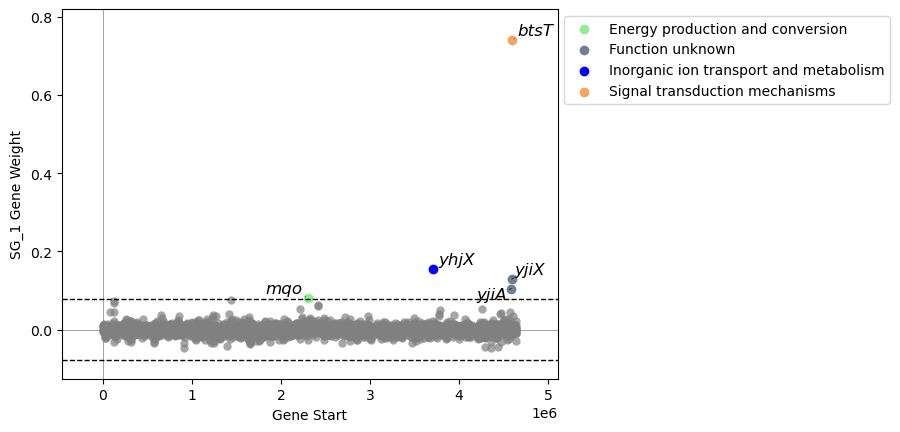

In [35]:
plot_gene_weights(ica_data,'SG_1')

# Characterization

In [36]:
# The antibiotics-exposed samples are under the project name "pilot"
pilot_index = ica_data.sample_table[ica_data.sample_table.project=='pilot'].index

In [37]:
for i in ica_data.imodulon_names:
    pilot_exp_var = explained_variance(ica_data,samples=pilot_index,imodulons=i)
    ica_data.imodulon_table.loc[i,'pilot_exp_var'] = pilot_exp_var
    
    exp_var = explained_variance(ica_data,imodulons=i)
    ica_data.imodulon_table.loc[i,'exp_var'] = exp_var
    
    ica_data.imodulon_table.loc[i,'imodulon_size'] = len(ica_data.view_imodulon(i))

In [38]:
ica_data.imodulon_table.head()

,regulator,pvalue,qvalue,precision,recall,f1score,TP,regulon_size,imodulon_size,n_regs,single_gene,pilot_exp_var,exp_var,category,phase
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,137,NaN,NaN,0.003090,0.003780,NaN,NaN
1,Fur,1.685496e-44,5.393588e-43,0.820513,0.250000,0.383234,32.0,128.0,39,1.0,NaN,0.021712,0.018648,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52,NaN,NaN,0.002387,0.013845,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23,NaN,NaN,0.000159,0.003153,NaN,NaN
4,RpoH,1.808843e-41,5.245645e-40,0.815789,0.219858,0.346369,31.0,141.0,38,1.0,NaN,0.009606,0.009124,NaN,NaN


In [39]:
# Check iModulon Membership
ica_data.view_imodulon(103)

,gene_weight,gene_name,accession,old_locus_tag,start,end,strand,gene_product,COG,uniprot,operon,regulator
b0005,0.075048,yaaX,U00096.3,NaN,5234.0,5530.0,+,DUF2502 domain-containing protein YaaX,Function unknown,P75616,Op1,Lrp
b0220,0.141688,ivy,U00096.3,NaN,240343.0,240816.0,+,periplasmic chaperone%2C inhibitor of vertebra...,"Post-translational modification, protein turno...",P0AD59,Op116,"ppGpp,Nac"
b0379,0.291188,yaiY,U00096.3,NaN,399025.0,399333.0,-,DUF2755 domain-containing inner membrane prote...,Function unknown,P0AAP7,Op209,"Lrp,Nac"
b0412,0.075158,yajI,U00096.3,NaN,432312.0,432851.0,-,putative lipoprotein YajI,Cell wall/membrane/envelope biogenesis,P46122,Op232,YfeC
b1110,0.273493,ycfJ,U00096.3,NaN,1167599.0,1168138.0,+,PF05433 family protein YcfJ,Function unknown,P0AB35,Op633,Lrp
b1171,0.164000,ymgD,U00096.3,NaN,1222305.0,1222634.0,-,PF16456 family protein YmgD,No COG annotation,P0AB46,Op669,NaN
b1172,0.201889,ymgG,U00096.3,NaN,1222644.0,1222988.0,-,PF13436 family protein YmgG,Function unknown,Q7DFV3,Op669,gcvB
b4593,0.134208,ymgI,U00096.3,NaN,1222990.0,1223163.0,-,uncharacterized protein YmgI,No COG annotation,A5A611,Op670,NaN
b1283,0.174549,osmB,U00096.3,NaN,1343110.0,1343328.0,-,osmotically-inducible lipoprotein OsmB,Cell wall/membrane/envelope biogenesis,P0ADA7,Op747,"RpoD,RcsB,omrA,RpoS,Nac,ppGpp"
b1379,0.150965,hslJ,U00096.3,NaN,1441321.0,1441743.0,-,lipoprotein implicated in Novobiocin resistance,"Post-translational modification, protein turno...",P52644,Op803,"RpoD,CysB"


<AxesSubplot:xlabel='Gene Start', ylabel='103 Gene Weight'>

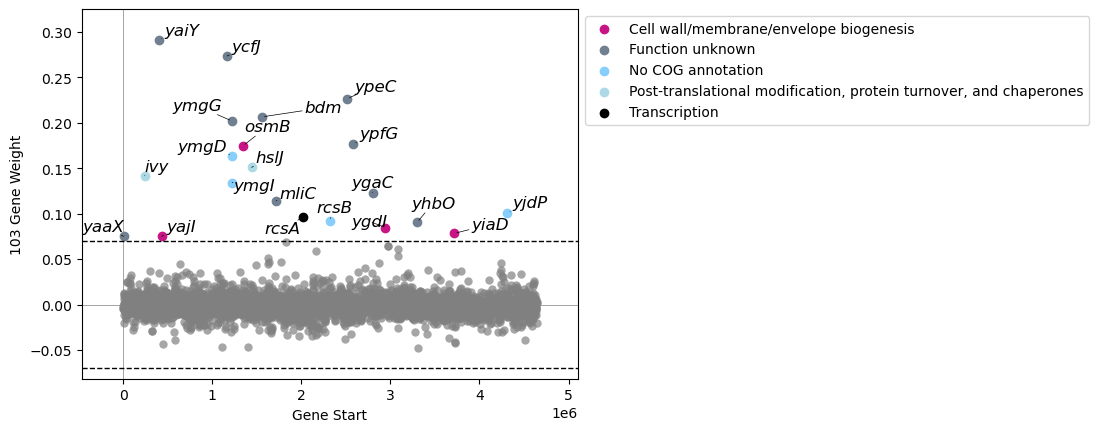

In [40]:
plot_gene_weights(ica_data,103,show_labels=True)

<AxesSubplot:ylabel='103 iModulon\nActivity'>

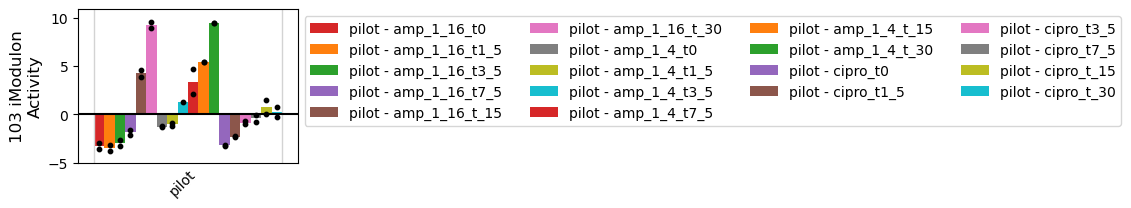

In [41]:
# Inspect iModulon Activity
plot_activities(ica_data,103,projects='pilot')

In [42]:
# To rename an iModulon
ica_data.rename_imodulons({103:'Rcs-1'})

In [43]:
# Label the functional category and response phase
ica_data.imodulon_table.loc['Rcs-1','category'] = 'Envelope Stress'
ica_data.imodulon_table.loc['Rcs-1','phase'] = 'Tertiary'

# Save iModulon object

This will save your iModulon table, your thresholds, and any other information stored in the ica_data object.

In [44]:
save_to_json(ica_data,'../interim/raw.json.gz')

If you prefer to view and edit your iModulon table in excel, save it as a CSV and reload the iModulon as before

In [45]:
ica_data.imodulon_table.to_csv('../interim/imodulon_table_raw.csv')